# TSP Belgium

### summary 

finds the shortest route between all the 581 municipalities (gemeentes) in Belgium

"as the crow flies" / "in vogelvlucht"

the dataset was gathered and processed in a different notebook

The result is a walk of distance: 3931.12 km

If we were using not only all municipalities but also all villages (gemeentes/ deelgemeentes),
it would be more complex to create a proper dataset.
The dataset would amount to around 3000 places 
which would make the christofides algorithm run for several hours on my machine
and would result in a walk of over 10000km

#### next steps
- use distance by walking paths as weights in calculation in stead of the straight line
- solve manually with genetic algorithm

maybe
- make dataset of all villages


In [ ]:
!pip3 install networkx matplotlib numpy geopy folium

In [ ]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
import json
import folium

## helper functions

In [4]:
def getTestData(feature_collection, amount):
    subset_features = feature_collection['features'][:amount]
    feature_collection = {
        "type": "FeatureCollection",
        "features": subset_features
    }
    return feature_collection


# Function to calculate distances between points
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

## load data

In [5]:
# Path to the GeoJSON file
filename = 'municipalities.geojson'

# Read the GeoJSON file
with open(filename, 'r') as file:
    feature_collection = json.load(file)

# Print the number of features
num_features = len(feature_collection['features'])
print("Number of features:", num_features)

Number of features: 511


## show on map

In [ ]:
m = folium.Map(location=[50.55, 4.34878], zoom_start=8)

# Function to add red circles
def add_circles(map_object, data):
    for feature in data['features']:
        if feature['geometry']['type'] == 'Point':
            coords = feature['geometry']['coordinates']
            name = feature['properties'].get('name', 'No Name')  # Default to 'No Name' if none found
            tooltip = folium.Tooltip(f"{name}", permanent=False)
            folium.CircleMarker(
                location=[coords[1], coords[0]],
                radius=5,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
                tooltip=tooltip
            ).add_to(map_object)

# Apply the function to add circles
add_circles(m, feature_collection)

# Display the map
m

## create graph

In [7]:
# Create a graph
G = nx.Graph()

In [8]:
# Prepare nodes and add them to the graph
nodes = []
for feature in feature_collection['features']:
    name = feature['properties']['name']
    coords = tuple(feature['geometry']['coordinates'][::-1]) # Reverse to (lat, lon)
    nodes.append((name, coords))
    G.add_node(name, coordinates=coords)

581 nodes = 15s

1000 nodes = 44s

2000 nodes = 180s

3363 nodes = 8m29s

In [9]:
# Add edges with distances as weights
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        node1_name, node1_coords = nodes[i]
        node2_name, node2_coords = nodes[j]
        distance = calculate_distance(node1_coords, node2_coords)
        G.add_edge(node1_name, node2_name, weight=distance)

### Optimize graph

For the used algorithms we need a fully connected graph
Which means A lot of nodes are useless

In [10]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Is the graph connected?", "Yes" if nx.is_connected(G) else "No")

Number of nodes: 511
Number of edges: 130305
Is the graph connected? Yes


## solve TSP

### Greedy algorithm

Basic cheap algorithm
Total distance: 4320.76 km

In [11]:
def getGreedyRoute(start_node):    
    if start_node in G:
        print("TSP Route starting from", start_node, ":", tsp_route)
        return nx.approximation.greedy_tsp(G, source=start_node, weight='weight')
    else:
        print(start_node, "not found in the data")
        
# tsp_route = getGreedyRoute("Hove")

###  Christofides

581 nodes = 6.6s

Total distance: 3940.77 km

In [12]:
tsp_route = nx.approximation.christofides(G, weight='weight')

In [13]:
# Start with specific node

start_node = 'Hove'  

# Check if the starting node exists in the graph
if start_node in G:
    
    # Rotate the tour to start at 'Hove'
    start_index = tsp_route.index(start_node)
    rotated_tsp_route = tsp_route[start_index:] + tsp_route[:start_index]
    tsp_route = rotated_tsp_route
    
    print("TSP Route using Christofides algorithm starting from", start_node, ":", tsp_route)
else:
    print(start_node, "not found in the data")

TSP Route using Christofides algorithm starting from Hove : ['Hove', 'Lint', 'Boechout', 'Borsbeek', 'Wommelgem', 'Wijnegem', 'Schilde', 'Halle', 'Zoersel', 'Malle', 'Brecht', 'Wuustwezel', 'Essen', 'Kalmthout', 'Kapellen', 'Stabroek', 'Brasschaat', 'Schoten', 'Ranst', 'Zandhoven', 'Nijlen', 'Berlaar', 'Grobbendonk', 'Vorselaar', 'Herentals', 'Olen', 'Herenthout', 'Lille', 'Kasterlee', 'Oud-Turnhout', 'Ravels', 'Baarle-Hertog', 'Hoogstraten', 'Rijkevorsel', 'Merksplas', 'Beerse', 'Vosselaar', 'Turnhout', 'Arendonk', 'Retie', 'Dessel', 'Mol', 'Geel', 'Meerhout', 'Ham', 'Balen', 'Lommel', 'Pelt', 'Hamont-Achel', 'Peer', 'Hechtel-Eksel', 'Leopoldsburg', 'Tessenderlo', 'Vorst', 'Laakdal', 'Westerlo', 'Herselt', 'Hulshout', 'Heist-op-den-Berg', 'Begijnendijk', 'Tremelo', 'Rotselaar', 'Holsbeek', 'Herent', 'Leuven', 'Bertem', 'Oud-Heverlee', 'Bierbeek', 'Lubbeek', 'Boutersem', 'La Bruyère', 'Hoegaarden', 'Tienen', 'Glabbeek', 'Hélécine', 'Orp-Jauche', 'Landen', 'Gingelom', 'Linter', 'Zoutlee

In [14]:
# clean & verifiy route

# Example of a simple check when generating a route
def verify_route(route):
    for i in range(1, len(route)):
        if route[i] == route[i-1]:
            return False  # Indicates an issue in the route
    return True

def clean_route(route):
    cleaned_route = [route[0]]  # Start with the first node
    for node in route[1:]:
        if node != cleaned_route[-1]:
            cleaned_route.append(node)
    return cleaned_route

tsp_route = clean_route(tsp_route)

# Use this function to check your initial route
if not verify_route(tsp_route):
    print("Invalid route detected: consecutive duplicate nodes found.")

## Other algorithms

- Convex Hull Method
- 2-Opt Algorithm
- Genetic Algorithms
- Integer Linear Programming (ILP) with Subtour Elimination
- Planar Graph Algorithms
- Gurobi optimization

### 2-Opt optimization

optimizes existing route
removes crossings

581 nodes = 4m42s

Total distance: 3662.63 km

In [ ]:
def two_opt(graph, initial_route):
    best_route = initial_route
    improved = True
    
    while improved:
        improved = False
        for i in range(1, len(best_route) - 2):
            for j in range(i + 1, len(best_route)):
                if j - i == 1: continue  # Skip consecutive nodes, as swapping them changes nothing
                new_route = best_route[:i] + best_route[i:j][::-1] + best_route[j:]
                
                # Calculate the cost of the routes
                old_distance = sum(graph[best_route[k]][best_route[k + 1]]['weight'] for k in range(len(best_route) - 1))
                new_distance = sum(graph[new_route[k]][new_route[k + 1]]['weight'] for k in range(len(new_route) - 1))
                
                # Check if the new route is better
                if new_distance < old_distance:
                    best_route = new_route
                    improved = True
        
        # If no improvement was found, exit the while loop
        if not improved:
            break

    return best_route

# Now apply the 2-opt algorithm to improve this route
optimized_route = two_opt(G, tsp_route)

In [ ]:
tsp_route = optimized_route

## plot result

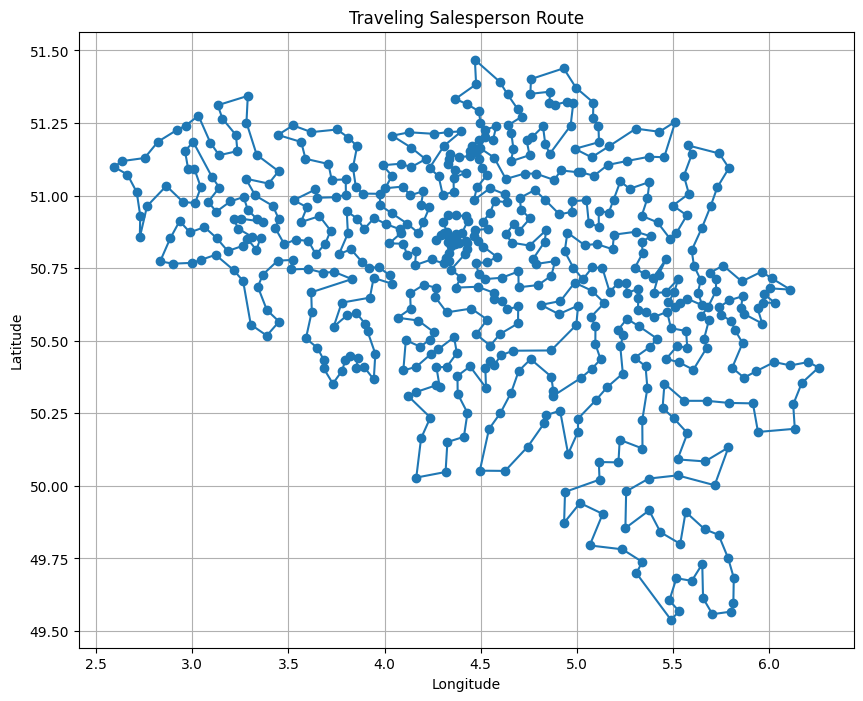

In [ ]:
# Plotting the route
coords = {feature['properties']['name']: tuple(feature['geometry']['coordinates'][::-1]) for feature in feature_collection['features']}
route_coords = [coords[place] for place in tsp_route]

# Unpack coordinates for plotting
lats, lons = zip(*route_coords)

plt.figure(figsize=(10, 8))
plt.plot(lons, lats, 'o-')  # Plot points with lines between them

# for i, txt in enumerate(tsp_route):
#     plt.annotate(txt, (lons[i], lats[i]))

plt.title('Traveling Salesperson Route')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## output routes

In [ ]:
# Prepare to list the route with distances
route_with_distances = []

previous_place = None
total_distance = 0

# Iterate through the route
for place in tsp_route:
    if previous_place is not None:
        # Get coordinates
        coord1 = coords[previous_place]
        coord2 = coords[place]

        # Calculate distance
        distance = calculate_distance(coord1, coord2)
        total_distance += distance

        # Append to the route list
        route_with_distances.append({
            "from": previous_place,
            "to": place,
            "distance": f"{distance:.2f} km"
        })
    
    previous_place = place

# Optionally, to make the route circular
if len(tsp_route) > 1:
    first_place = tsp_route[0]
    last_place = tsp_route[-1]
    coord1 = coords[last_place]
    coord2 = coords[first_place]
    distance = calculate_distance(coord1, coord2)
    total_distance += distance
    route_with_distances.append({
        "from": last_place,
        "to": first_place,
        "distance": f"{distance:.2f} km"
    })

# Print the route with distances
for leg in route_with_distances:
    print(f"{leg['from']} -> {leg['to']} = {leg['distance']}")

# Print total distance
print(f"Total distance: {total_distance:.2f} km")


Hove -> Boechout = 2.13 km
Boechout -> Lier = 6.27 km
Lier -> Putte = 9.29 km
Putte -> Heist-op-den-Berg = 7.16 km
Heist-op-den-Berg -> Hulshout = 4.20 km
Hulshout -> Herselt = 7.07 km
Herselt -> Westerlo = 4.38 km
Westerlo -> Laakdal = 6.38 km
Laakdal -> Vorst = 0.90 km
Vorst -> Tessenderlo = 5.04 km
Tessenderlo -> Ham = 6.51 km
Ham -> Leopoldsburg = 7.29 km
Leopoldsburg -> Hechtel-Eksel = 8.24 km
Hechtel-Eksel -> Peer = 5.37 km
Peer -> Hamont-Achel = 14.26 km
Hamont-Achel -> Pelt = 6.98 km
Pelt -> Lommel = 8.62 km
Lommel -> Balen = 11.72 km
Balen -> Meerhout = 7.79 km
Meerhout -> Geel = 6.90 km
Geel -> Mol = 9.12 km
Mol -> Dessel = 6.13 km
Dessel -> Retie = 3.74 km
Retie -> Arendonk = 5.86 km
Arendonk -> Ravels = 8.54 km
Ravels -> Baarle-Hertog = 8.65 km
Baarle-Hertog -> Hoogstraten = 12.52 km
Hoogstraten -> Rijkevorsel = 5.67 km
Rijkevorsel -> Merksplas = 7.31 km
Merksplas -> Beerse = 4.34 km
Beerse -> Vosselaar = 2.29 km
Vosselaar -> Turnhout = 4.39 km
Turnhout -> Oud-Turnhout = 2.